In [33]:
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import scipy as sp
from tqdm import tqdm

## Initialise Constants

In [34]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

In [2]:
loop1 = sq.Loop()
loop2 = sq.Loop()

In [3]:
EJ_val = 121
CJ_val = 8
Cr_val = 100
Cc_val = 8
Lr_val = 10
alpha = 0.4
ng_val = 0.5
flux_val = 0

In [4]:
# define the circuit elements
Cc = sq.Capacitor(Cc_val, unit='fF')
Cr = sq.Capacitor(Cr_val, unit='fF')
Lr = sq.Inductor(Lr_val, unit='nH', loops=[loop2])
JJ = sq.Junction(EJ_val, 'GHz', loops=[loop1])
alpha_JJ = sq.Junction(alpha * EJ_val, 'GHz', loops=[loop1])
CJ = sq.Capacitor(CJ_val, unit='fF')
alpha_CJ = sq.Capacitor(alpha * CJ_val, unit='fF')

In [5]:
# define the circuit
qubit_elements = {
    (0, 1): [alpha_JJ, alpha_CJ],
    (1, 2): [JJ, CJ],
    (2, 3): [JJ, CJ],
    (3, 0): [alpha_JJ, alpha_CJ],
}
circuit_elements = {
    (0, 1): [alpha_JJ, alpha_CJ],
    (1, 2): [JJ, CJ],
    (2, 3): [JJ, CJ],
    (3, 0): [alpha_JJ, alpha_CJ],
    (0, 4): [Cc],
    (4, 4): [Lr, Cr],
}

qubit_cr = sq.Circuit(qubit_elements, flux_dist='all')
cr = sq.Circuit(circuit_elements, flux_dist='all')

In [6]:
qubit_cr.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
cr.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
# Set truncation numbers, desired eigenvalues, and flux sweep
n1 = 10 # harmonic
n2 = 10 # charge
n3 = 10 # charge
n4 = 10 # charge

ng = 0.25

qubit_cr.set_trunc_nums([n2, n3, n4])
cr.set_trunc_nums([n1, n2, n3, n4])

qubit_cr.set_charge_offset(1, ng)
cr.set_charge_offset(2, ng)

In [9]:
qubit_cr_evals, qubit_cr_evecs = qubit_cr.diag(2)

qubit_0 = qubit_cr_evecs[0]
qubit_1 = qubit_cr_evecs[1]
qubit_m = 2**-0.5 * (qubit_0 - qubit_1)
qubit_p = 2**-0.5 * (qubit_0 + qubit_1)

fock_0 = qt.basis(n1, 0)
fock_1 = qt.basis(n1, 1)
fock_m = 2**-0.5 * (fock_0 - fock_1)
fock_p = 2**-0.5 * (fock_0 + fock_1)

ket_00 = qt.tensor(fock_0, qubit_0)
ket_01 = qt.tensor(fock_1, qubit_0)
ket_10 = qt.tensor(fock_0, qubit_1)
ket_11 = qt.tensor(fock_1, qubit_1)
ket_0m = qt.tensor(fock_m, qubit_0)
ket_0p = qt.tensor(fock_p, qubit_0)
ket_p1 = qt.tensor(fock_1, qubit_p)
ket_m0 = qt.tensor(fock_0, qubit_m)

In [10]:
circuit_H = cr.hamiltonian()

g_parr = -1j * circuit_H.matrix_element(ket_p1.conj(), ket_m0)
g_perp = circuit_H.matrix_element(ket_11.conj(), ket_00)
delta = 2 * circuit_H.matrix_element(ket_00.conj(), ket_00)
omega = 2 * circuit_H.matrix_element(ket_01.conj(), ket_01) - 0.5 * delta

print(f"g parallel: {g_parr}")
print(f"g perpendicular: {g_perp}")
print(f"delta: {delta}")
print(f"omega: {omega}")

g parallel: -0j
g perpendicular: 0j
delta: (1584091144433.013+2977491548324.536j)
omega: (762339978113.8698+1432910505030.5635j)


## Plotting

In [36]:
def calc_g(Cc_val=8, Cr_val=100, Lr_val=10, EJ_val=121, CJ_val=8, alpha=0.4, flux=0):
    # define the circuit elements
    Cc = sq.Capacitor(Cc_val, unit='fF')
    Cr = sq.Capacitor(Cr_val, unit='fF')
    Lr = sq.Inductor(Lr_val, unit='nH', loops=[loop2])
    JJ = sq.Junction(EJ_val, 'GHz', loops=[loop1])
    alpha_JJ = sq.Junction(alpha * EJ_val, 'GHz', loops=[loop1])
    CJ = sq.Capacitor(CJ_val, unit='fF')
    alpha_CJ = sq.Capacitor(alpha * CJ_val, unit='fF')

    circuit_elements = {
        (0, 1): [alpha_JJ, alpha_CJ],
        (1, 2): [JJ, CJ],
        (2, 3): [JJ, CJ],
        (3, 0): [alpha_JJ, alpha_CJ],
        (0, 4): [Cc],
        (4, 4): [Lr, Cr],
    }

    cr = sq.Circuit(circuit_elements, flux_dist='all')

    # Set truncation numbers, desired eigenvalues, and flux sweep
    n1 = 10 # harmonic
    n2 = 10 # charge
    n3 = 10 # charge
    n4 = 10 # charge

    ng = 0.25

    cr.set_trunc_nums([n1, n2, n3, n4])

    cr.set_charge_offset(2, ng)

    circuit_H = cr.hamiltonian()

    circuit_H_qubit = circuit_H.ptrace([1, 2, 3])

    qubit_evals, qubit_evecs = sp.sparse.linalg.eigsh(circuit_H_qubit.data, 2)
    qubit_evecs = qubit_evecs.T

    qubit_0 = qubit_evecs[0]
    qubit_1 = qubit_evecs[1]
    qubit_m = 2**-0.5 * (qubit_0 - qubit_1)
    qubit_p = 2**-0.5 * (qubit_0 + qubit_1)

    g_parr = qubit_p.conj() @ circuit_H_qubit.data @ qubit_m
    g_perp = qubit_1.conj() @ circuit_H_qubit.data @ qubit_0

    print(f"g parallel: {g_parr}")
    print(f"g perpendicular: {g_perp}")
    
    return g_parr, g_perp

In [37]:
Ccs = [val for val in range(11)]
g_parrs = []

for Cc in tqdm(Ccs):
    g_parr, g_perp = calc_g(Cc_val=Cc)
    g_parrs.append(g_parr)

  9%|████                                        | 1/11 [00:06<01:05,  6.53s/it]

g parallel: (6176574792327.344+0.03125j)
g perpendicular: (1.7599449114960635+0.011976095021381639j)


 18%|████████                                    | 2/11 [00:11<00:51,  5.67s/it]

g parallel: (6176574792327.234-0.0859375j)
g perpendicular: (0.34404387908850254-0.05370261780410601j)


 27%|████████████                                | 3/11 [00:16<00:42,  5.35s/it]

g parallel: (6176574792326.336+0.0625j)
g perpendicular: (1.1585243739053794+0.0341639151953359j)


 36%|████████████████                            | 4/11 [00:21<00:36,  5.18s/it]

g parallel: (6176574792326.227-0.03125j)
g perpendicular: (0.5280618374223423-0.015448118326602867j)


 45%|████████████████████                        | 5/11 [00:26<00:30,  5.08s/it]

g parallel: (6176574792327.711-0.00390625j)
g perpendicular: (1.0111864296255817+0.020303272416924756j)


 55%|████████████████████████                    | 6/11 [00:31<00:25,  5.02s/it]

g parallel: (6176574792326.081+0.01171875j)
g perpendicular: (0.3051839120089702+0.010812470736299318j)


 64%|████████████████████████████                | 7/11 [00:36<00:19,  4.93s/it]

g parallel: (6176574792327.5625-0.0234375j)
g perpendicular: (0.11538871805817053-0.036519628504507295j)


 73%|████████████████████████████████            | 8/11 [00:40<00:14,  4.87s/it]

g parallel: (6176574792326.662+0.015625j)
g perpendicular: (1.5609233796196804+0.028067980793025527j)


 82%|████████████████████████████████████        | 9/11 [00:45<00:09,  4.84s/it]

g parallel: (6176574792325.969-0.0703125j)
g perpendicular: (0.1405185517968084-0.06742965451905647j)


 91%|███████████████████████████████████████    | 10/11 [00:50<00:04,  4.81s/it]

g parallel: (6176574792327.539+0.0078125j)
g perpendicular: (-0.0057161491992872016-0.02174308380472212j)


100%|███████████████████████████████████████████| 11/11 [00:55<00:00,  5.02s/it]

g parallel: (6176574792327.037+0.01318359375j)
g perpendicular: (1.1509349351874656+0.01817935765142753j)


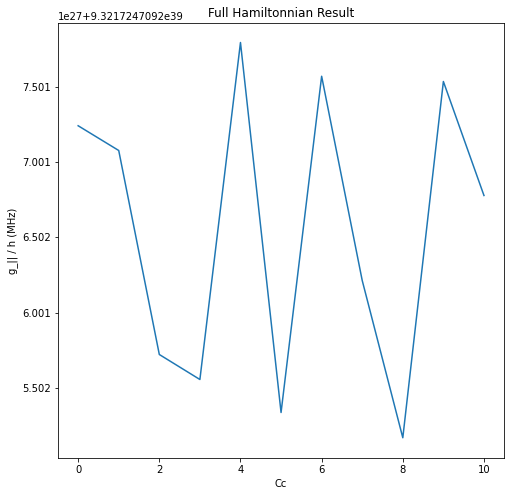

In [40]:
plt.figure(figsize=(8, 8))

plt.title('Full Hamiltonnian Result')
plt.xlabel('Cc')
plt.ylabel('g_|| / h (MHz)')
plt.plot(Ccs, [np.real(g_parr * 1e-6) / h for g_parr in g_parrs])